# Wターム

## シミュレーションコード
ここでは磁気流体力学数値シミュレーションコード https://github.com/zenitani/OpenMHD を使用する．

## 基礎方程式
$$
\renewcommand{\bm}[1]{{\mathit{\boldsymbol{#1}}}} % macro definition
$$

このシミュレーションで解いている基礎方程式は以下の磁気流体力学方程式（いわゆるLorentz-Heaviside単位系）である．
$$
\begin{aligned}
    & \frac{\partial}{\partial t} \left( \rho \right )
    + \nabla \cdot \left( \rho \bm{v} \right) = 0,
    \\
    & \frac{\partial}{\partial t} \left( \rho \bm{v} \right)
    + \nabla \cdot \left[
        \rho \bm{v} \bm{v} + \left(p + \frac{B^2}{2} \right) \bm{I} - \bm{B} \bm{B}
    \right] = 0,
    \\
    & \frac{\partial}{\partial t} \left( \frac{1}{2} \rho \bm{v}^2 + \frac{1}{\gamma - 1} p + \frac{\bm{B^2}}{2}\right)
    + \nabla \cdot \left[
        \left( \frac{1}{2} \rho \bm{v}^2 + \frac{\gamma}{\gamma - 1} p + \frac{\bm{B^2}}{2} \right) \bm{v}
        - \left( \bm{v} \cdot \bm{B} \right) \bm{B}
    \right] = 0,
    \\
    &
    \frac{\partial}{\partial t} \left( \bm{B} \right)
    - \nabla \times \left( \bm{v} \times \bm{B} \right) = 0.
\end{aligned}
$$

## シミュレーションの設定
ここでは簡単のため，1次元の標準的なテスト問題（Riemann問題または衝撃波管問題）を扱う．  
計算領域は $-0.5 < x < +0.5$ であり，初期条件として $x < 0$ および $x > 0$ で  
それぞれ別の物理状態が与えられたときの時間発展を求める問題である．

ソースコードは `OpenMHD/1D_basic` にあり，計算設定を変えるには主に `main.f90` と  
`model.f90` を編集することになる．  
例えば初期条件を変えるには `model.f90` を編集すればよい．  
また `main.f90`では以下の量が定義されているので，必要に応じて変更すればよい．  
- 格子点数 （`ix = 302`）
- 終了時間 （`tend = 0.2d0`）
- 出力間隔 （`dtout = 0.1d0`）
- 時間ステップのCFL数 （`cfl = 0.8d0`）


In [1]:
Nx = 302 # 格子点数
step = 1 # 出力するステップ

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

### データ読み込み

In [3]:
def read_datafiles(dirname, Nx):
    import glob

    fpattern = os.sep.join([dirname, "x-*.dat"])
    datafile = sorted(glob.glob(fpattern))

    Nt = len(datafile)
    ro = np.zeros((Nt, Nx))
    pr = np.zeros((Nt, Nx))
    vx = np.zeros((Nt, Nx))
    vy = np.zeros((Nt, Nx))
    vz = np.zeros((Nt, Nx))
    bx = np.zeros((Nt, Nx))
    by = np.zeros((Nt, Nx))
    bz = np.zeros((Nt, Nx))

    for i, f in enumerate(datafile):
        data = np.loadtxt(f)
        xx = data[:, 0]
        ro[i, :] = data[:, 2]
        pr[i, :] = data[:, 3]
        vx[i, :] = data[:, 4]
        vy[i, :] = data[:, 5]
        vz[i, :] = data[:, 6]
        bx[i, :] = data[:, 7]
        by[i, :] = data[:, 8]
        bz[i, :] = data[:, 9]
    return xx, ro, pr, vx, vy, vz, bx, by, bz


def plot_snapshot(dirname, Nx, step):
    xx, ro, pr, vx, vy, vz, bx, by, bz = read_datafiles(dirname, Nx)
    fig, axs = plt.subplots(5, figsize=(6, 10), sharex=True)

    plt.sca(axs[0])
    plt.plot(xx, ro[0], "k--")
    plt.plot(xx, ro[step])
    plt.ylabel(r"$\rho$")

    plt.sca(axs[1])
    plt.plot(xx, vx[0], "k--")
    plt.plot(xx, vx[step])
    plt.ylabel(r"$V_x$")

    plt.sca(axs[2])
    plt.plot(xx, vy[0], "k--")
    plt.plot(xx, vy[step])
    plt.ylabel(r"$V_y$")

    plt.sca(axs[3])
    plt.plot(xx, pr[0], "k--")
    plt.plot(xx, pr[step])
    plt.ylabel(r"$P$")

    plt.sca(axs[4])
    plt.plot(xx, by[0], "k--")
    plt.plot(xx, by[step])
    plt.ylabel(r"$B_y$")
    plt.xlabel(r"x")
    plt.xlim(-0.5, +0.5)
    fig.align_ylabels(axs)

### 結果のプロット
関数 `plot_snapshot` の第一引数にデータが出力されたディレクトリのパスを指定することで  
結果をプロットすることができる．例えば以下のように実行して結果をプロットしてみよう．

```python
>>> plot_snapshot('OpenMHD/1D_basic/data', Nx, step)
```

以下のような図が出力されれば成功である．

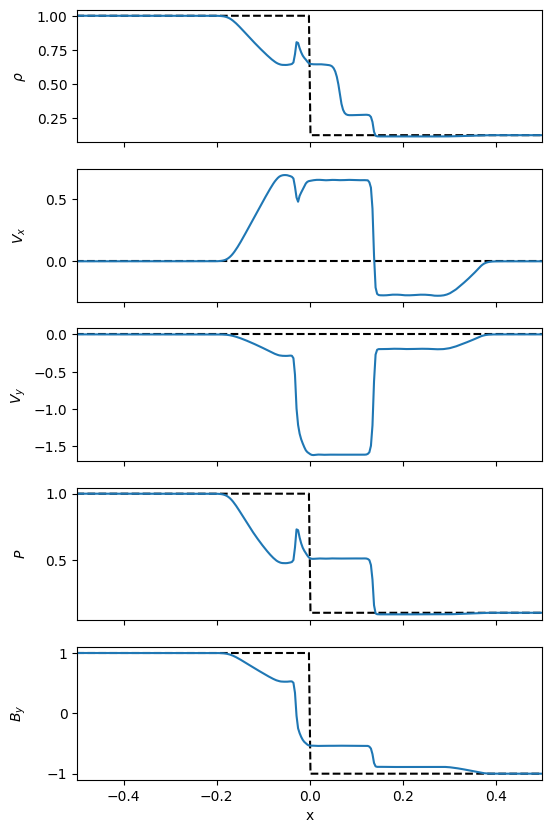

In [4]:
# デフォルト設定（あらかじめ計算済みのデータ）
dirname = "default"
plot_snapshot(dirname, Nx, step)

## 流体方程式の定常解（衝撃波と接触不連続面）

まずは簡単のため磁場の効果を無視した圧縮性流体方程式を考え，非線形な流体方程式の定常解である孤立した衝撃波と接触不連続面を再現してみよう．


### 衝撃波
- 衝撃波の静止系での接続条件はマッハ数$M = V_{x,1} / C_s = V_{x,1} / \sqrt{\gamma P_1 / \rho_1}$を使って
  $$
  \frac{\rho_2}{\rho_1} = \frac{V_{x,1}}{V_{x,2}} = \frac{(\gamma + 1) M^2}{(\gamma - 1) M^2 + 2},
  \quad
  \frac{p_2}{p_1} = \frac{2 \gamma M^2 - (\gamma - 1)}{\gamma + 1}
  $$
  と書ける．これを満たす初期条件として
  $$
  \left( \rho, V_{x}, p \right) =
  \begin{cases}
  \left(1.0, 1.0, 0.2 \right) \quad & x < 0 \\
  \left(2.0, 0.5, 0.7 \right) \quad & x > 0
  \end{cases}
  $$
  を採用し，初期条件が定常解になっていることを確かめよう．
  実行例は以下の通り．

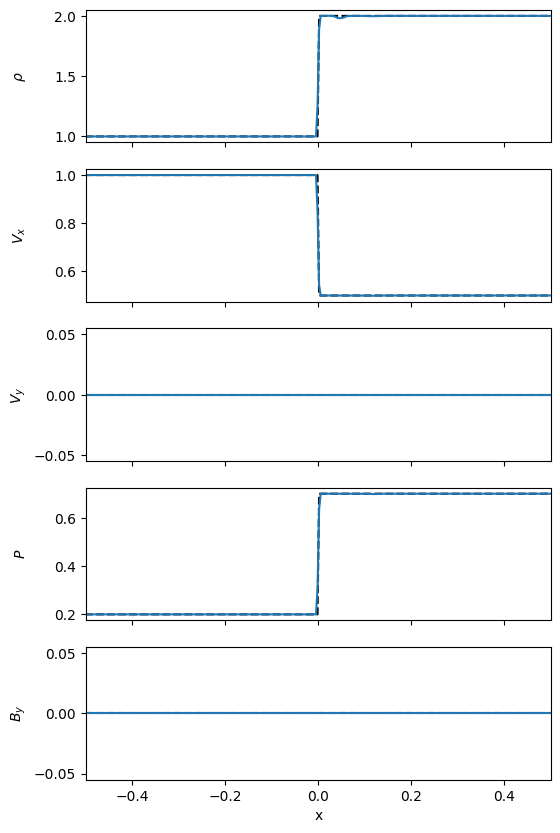

In [5]:
plot_snapshot("shock", Nx, step)

### 接触不連続面
- 当然ながら圧力バランスした構造($\rho_1 \neq \rho_2, V_{x,1} = V_{x,2} = 0, P_1 = P_2$)も流体方程式の定常解であり，接触不連続面と呼ばれる．  
  これを満たす初期条件として
  $$
  \left( \rho, V_{x}, p \right) =
  \begin{cases}
  \left(1.0, 0.0, 1.0 \right) \quad & x < 0 \\
  \left(2.0, 0.0, 1.0 \right) \quad & x > 0
  \end{cases}
  $$
  を採用し，同様にこれが定常解になっていることを確かめよう．
  実行例は以下の通り．

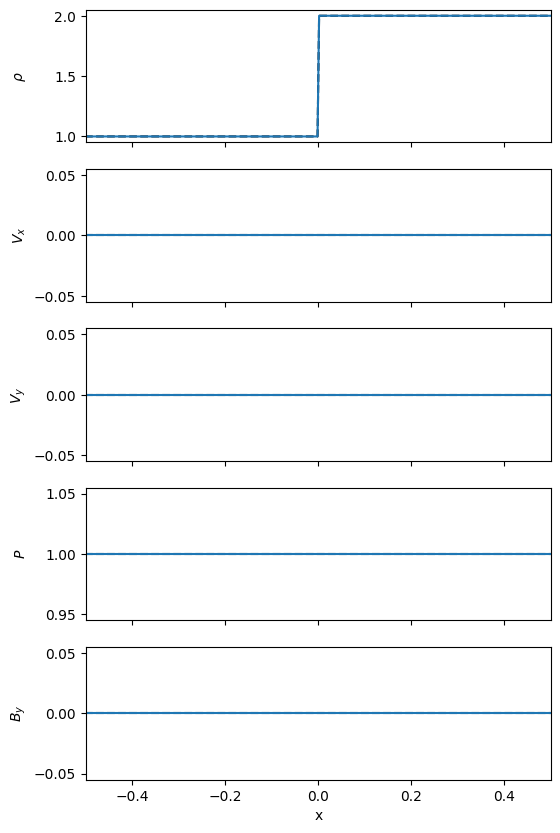

In [6]:
plot_snapshot("contact", Nx, step)


### 演習
- パラメータを変えて色々と試してみよう．初期に解析的な条件を満たしていないときにはどうなるだろうか？
- 一般に不連続面は観測者系に対して有限の速度で動いている．孤立した衝撃波や接触不連続面がシミュレーション系に  
対して動いている場合の解を作ってみよう．  
- 計算結果から有限の速度で動く不連続面の速度を見積もってみよう．
- 興味があればアニメーションを作ってみよう．

## 太陽風・磁気圏相互作用（磁場無し）
一般には初期条件に応じて複数の波動モード（不連続面または滑らかな波動）が生じて，左状態と右状態が接続される．  
ここでは太陽風と地球磁気圏の相互作用を考える．すなわち，超音速の太陽風（左状態）と静止した低密度・高圧の  
磁気圏（右状態）を接続するような解の例として以下を初期条件にとってみよう．
$$
\left( \rho, V_{x}, p \right) =
\begin{cases}
\left(1.0, 1.0, 0.8 \right) \quad & x < 0 \\
\left(0.1, 0.0, 2.8 \right) \quad & x > 0
\end{cases}
$$

実行例は以下の通り．

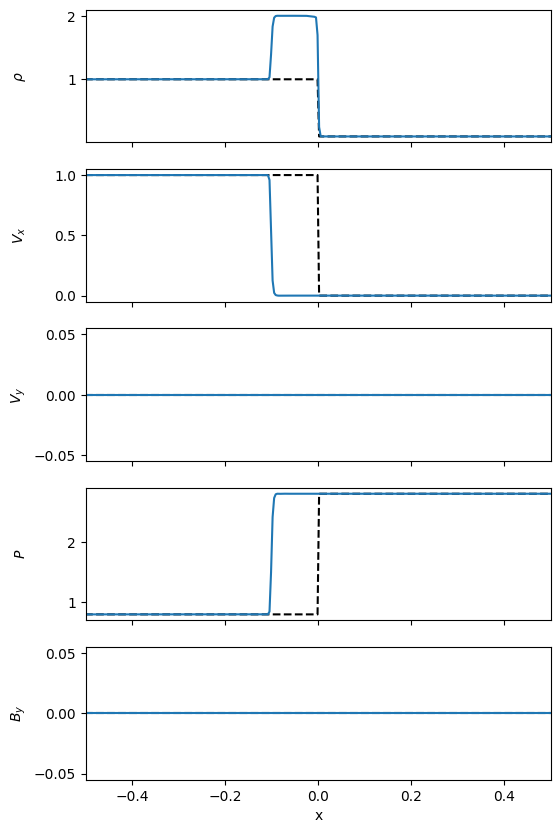

In [7]:
plot_snapshot("magnetopause1", Nx, step)

### 演習
- 右側の接触不連続面が静止していること，左側の衝撃波が左に動いていることを確認しよう．
- 衝撃波静止系で衝撃波面前後の接続条件が満たされていることを確認しよう．
- 実際の太陽風のマッハ数は5-10程度である．このときに磁気圏内が静止した解を構築するにはどうしたらよいだろうか？

## 太陽風・磁気圏相互作用（磁場有り）

実際には地球磁気圏は双極子磁場が優勢な領域のため，「圧力」は流体の熱的な圧力（ガス圧）ではなく，磁場の圧力（磁気圧）で支えられている．  
このような状況を表す解として以下を初期条件にとってみよう．
$$
\left( \rho, V_{x}, p, B_{y} \right) =
\begin{cases}
\left(1.0, 1.0, 0.78, 0.2, \right) \quad & x < 0 \\
\left(0.1, 0.0, 0.80, 2.0 \right)  \quad & x > 0
\end{cases}
$$

実行例は以下の通り．

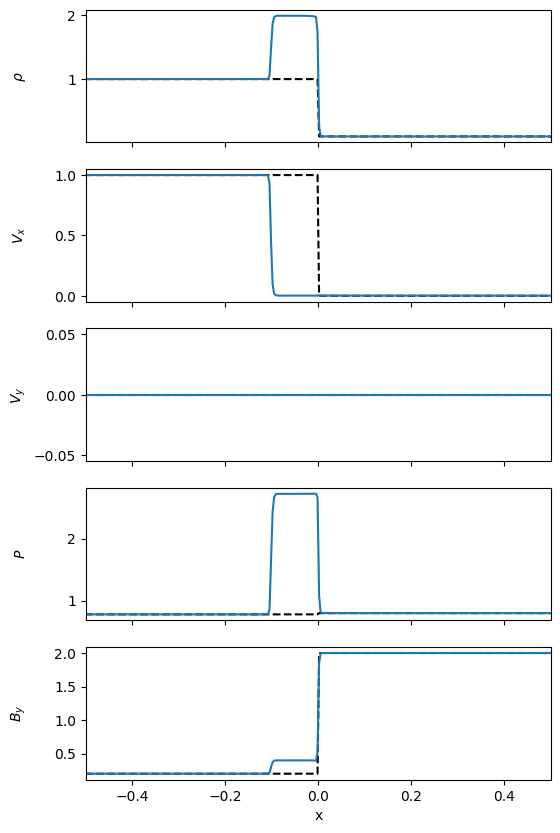

In [8]:
plot_snapshot("magnetopause2", Nx, step)

### 演習
- 右側の接触不連続面が静止していること，左側の衝撃波が左に動いていることを確認しよう．
- 接触不連続面前後で全圧力$P_{\rm tot} = P + \bm{B}^2/2$が一定になっていることを確認しよう．
- 磁場があるときの衝撃波面前後の接続条件はどうなるか考えてみよう．

## 発展編
- 太陽フレアなどに伴うコロナ質量放出では，周囲の太陽風より高速・高密のガスが惑星間空間に放出される．  
このような状況について考えてみよう．
- 太陽と地球を結ぶ線上からずれた場所では速度の接線成分（$V_y, V_z$）が有限になるだろう．この場合について考えてみよう．  
（余裕があれば2次元でKelvin-Helmoltz不安定性を考えよう．）
- 太陽風の磁場の向きはランダムに変化している．太陽風の磁場が地球の双極子磁場と違う向きの場合はどうなるだろうか？  
（余裕があれば2次元で磁気リコネクションについて考えよう．）